In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys

import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.externals import joblib
from sklearn import metrics
import lightgbm as lgb

sys.path.append('../')
from pipelines import solution_1
import pipeline_config as cfg

# EXPERIMENT_DIR = 'YOUR/PATH/TO/EXPERIMETS'
EXPERIMENT_DIR = '/mnt/ml-team/minerva/avito/kuba/experiments'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Solution 1

Local CV: **0.2278**
Public LB: **0.2351**

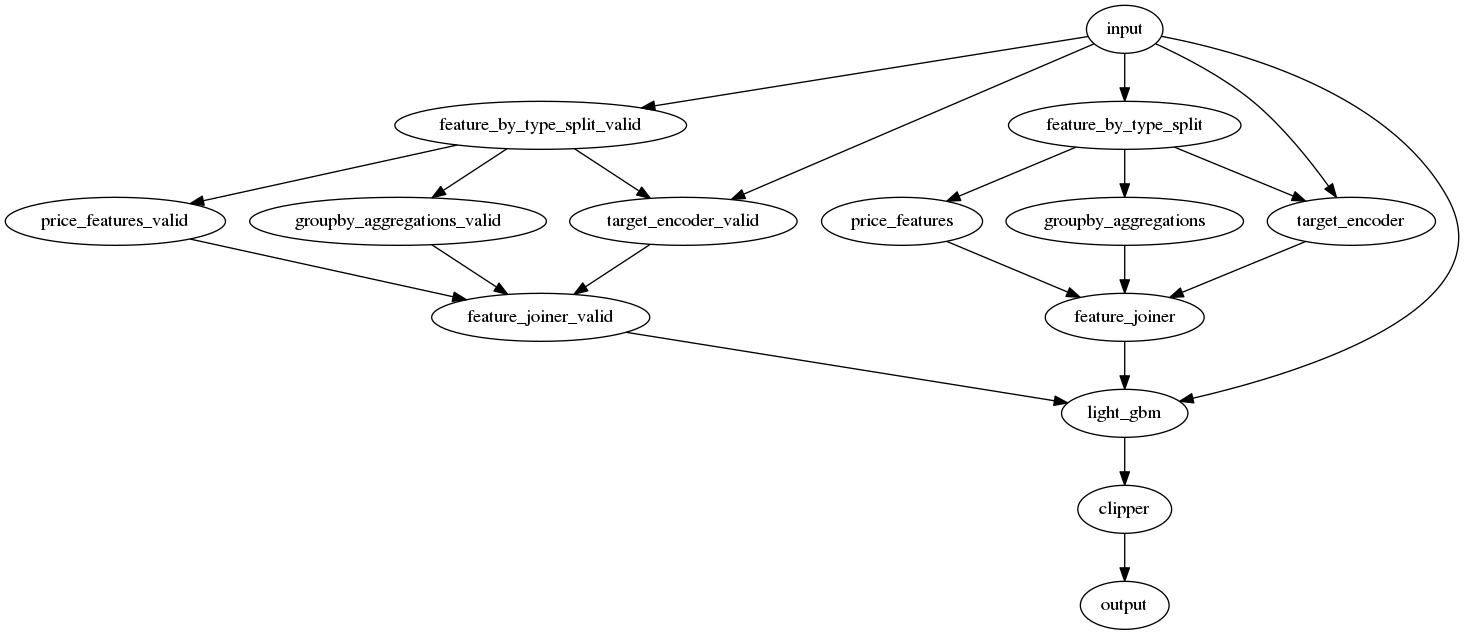

In [2]:
solution_1(cfg.SOLUTION_CONFIG, train_mode=True)

## Feature Extraction
* price features - for now just the price value
* target encoded features - likelihood encoding for categorical features
* groupby aggregations - features calculated based on aggregated categories

```python
    'groupby_aggregation': {'groupby_aggregations': [
        {'groupby': ['user_id'], 'select': 'price', 'agg': 'mean'},
        {'groupby': ['user_id'], 'select': 'price', 'agg': 'var'},
        {'groupby': ['user_id'], 'select': 'parent_category_name', 'agg': 'nunique'},
        {'groupby': ['parent_category_name'], 'select': 'price', 'agg': 'mean'},
        {'groupby': ['parent_category_name'], 'select': 'price', 'agg': 'var'},
        {'groupby': ['parent_category_name', 'category_name'], 'select': 'price', 'agg': 'mean'},
        {'groupby': ['parent_category_name', 'category_name'], 'select': 'price', 'agg': 'var'},
        {'groupby': ['region'], 'select': 'parent_category_name', 'agg': 'count'},
        {'groupby': ['city'], 'select': 'parent_category_name', 'agg': 'count'},
    ]},
```

## Models
* lightgbm with the following parameters

```yaml
  lgbm_random_search_runs: 0
  lgbm__boosting_type: 'gbdt'
  lgbm__objective: regression
  lgbm__metric: RMSE
  lgbm__number_boosting_rounds: 300
  lgbm__early_stopping_rounds: 30
  lgbm__learning_rate: 0.05
  lgbm__num_leaves: 77
  lgbm__max_depth: 11
  lgbm__min_child_samples: 44
  lgbm__max_bin: 379
  lgbm__subsample: 0.82
  lgbm__subsample_freq: 2
  lgbm__colsample_bytree: 0.27
  lgbm__min_child_weight: 4
  lgbm__reg_lambda: 0.0
  lgbm__reg_alpha: 0.1
```

## Model exploration

In [11]:
model_filepath = os.path.join(EXPERIMENT_DIR, 'solution_1', 'transformers','light_gbm')
light_gbm_model = joblib.load(model_filepath)

### Learning Curve

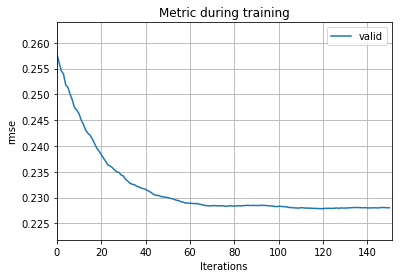

In [12]:
ax = lgb.plot_metric(light_gbm_model['evals_result'], metric='rmse')
plt.show()

### Feature Importance

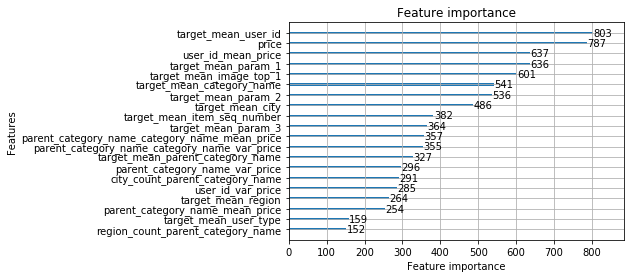

In [13]:
ax = lgb.plot_importance(light_gbm_model['estimator'], max_num_features=20)
plt.show()

## Result Exploration

In [3]:
prediction_filepath = os.path.join(EXPERIMENT_DIR, 'solution_1', 'evaluation_predictions.csv')
evaluation_predictions =  pd.read_csv(prediction_filepath)

In [4]:
top_n = 100
best_predictions = evaluation_predictions.sort_values('score', ascending=True)[:top_n]
worst_predictions = evaluation_predictions.sort_values('score', ascending=False)[:top_n]

In [5]:
worst_predictions.head(3)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,y_pred,score
300684,6f9064244726,cb6537262a06,Свердловская область,Екатеринбург,Услуги,Предложение услуг,"Красота, здоровье",NaN,NaN,Парикмахер на дому и с выездом на дом,"Дорогие девушки и женщины! Стилист, с опытом р...",NaN,763,2017-03-15,Company,d4953d3d17cf4d2437d748d0cda5c70d3a4c3053ca4e9d...,248.0,1.00000,0.110689,0.889311
300683,b0b51242ab46,4fad0ffde337,Челябинская область,Челябинск,Для дома и дачи,Бытовая техника,Для кухни,Холодильники и морозильные камеры,NaN,Холодильник stinol-123,"включается, работает, но не морозит. требуется...",1500.0,42,2017-03-18,Private,c323d4d569abf5884d5e77b577f872f0fcd9b58763c8e5...,1787.0,0.00000,0.878445,0.878445
300682,af6b052aa6f5,bafb59303191,Алтайский край,Барнаул,Для дома и дачи,Посуда и товары для кухни,Товары для кухни,NaN,NaN,Мясорубка,В таком состоянии.,100.0,814,2017-03-28,Company,b54459359524194eaf54e0d066b0efb8a0ee34748a5808...,1712.0,0.86521,0.000000,0.865210


# ELI5

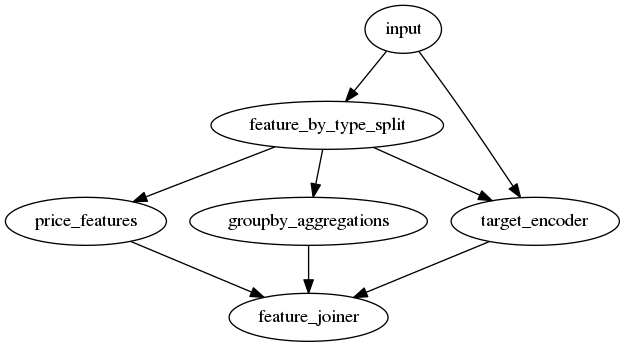

In [6]:
feature_extraction = solution_1(cfg.SOLUTION_CONFIG, train_mode=False).get_step('feature_joiner')
feature_extraction

In [8]:
data = {'input': {'X': evaluation_predictions[cfg.FEATURE_COLUMNS],
                  'y': None,
                 },
            }

features = feature_extraction.transform(data)

2018-05-12 00-06-32 steps >>> step feature_by_type_split adapting inputs
2018-05-12 00-06-32 steps >>> step feature_by_type_split loading transformer...
2018-05-12 00-06-32 steps >>> step feature_by_type_split transforming...
2018-05-12 00-06-32 steps >>> step price_features adapting inputs
2018-05-12 00-06-32 steps >>> step price_features loading transformer...
2018-05-12 00-06-32 steps >>> step price_features transforming...
2018-05-12 00-06-32 steps >>> step price_features caching outputs...
2018-05-12 00-06-32 steps >>> step feature_by_type_split adapting inputs
2018-05-12 00-06-32 steps >>> step feature_by_type_split loading transformer...
2018-05-12 00-06-32 steps >>> step feature_by_type_split transforming...
2018-05-12 00-06-32 steps >>> step target_encoder adapting inputs
2018-05-12 00-06-32 steps >>> step target_encoder loading transformer...
2018-05-12 00-06-32 steps >>> step target_encoder transforming...
2018-05-12 00-06-34 steps >>> step target_encoder caching outputs...


In [10]:
features['features'].head()

,price,target_mean_user_id,target_mean_region,target_mean_city,target_mean_parent_category_name,target_mean_category_name,target_mean_param_1,target_mean_param_2,target_mean_param_3,target_mean_item_seq_number,...,target_mean_is_nan_region,target_mean_is_nan_city,target_mean_is_nan_parent_category_name,target_mean_is_nan_category_name,target_mean_is_nan_param_1,target_mean_is_nan_param_2,target_mean_is_nan_param_3,target_mean_is_nan_item_seq_number,target_mean_is_nan_user_type,target_mean_is_nan_image_top_1
0,120.0,0.0,0.146726,0.137842,0.124169,0.147400,0.087377,0.000000,0.000000,0.084020,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,6900.0,0.0,0.121954,0.123361,0.076014,0.198943,0.210847,0.000000,0.000000,0.024997,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,700.0,0.0,0.120552,0.114295,0.076014,0.061163,0.068473,0.075857,0.054648,0.154937,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,45.0,0.0,0.146082,0.137696,0.076014,0.046253,0.057126,0.000000,0.000000,0.130780,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,600.0,0.0,0.135423,0.094092,0.076014,0.046253,0.041267,0.062868,0.032183,0.165875,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
features['features'].iloc[0]

price                                            1.200000e+02
target_mean_user_id                              0.000000e+00
target_mean_region                               1.467256e-01
target_mean_city                                 1.378419e-01
target_mean_parent_category_name                 1.241691e-01
target_mean_category_name                        1.473997e-01
target_mean_param_1                              8.737667e-02
target_mean_param_2                              0.000000e+00
target_mean_param_3                              0.000000e+00
target_mean_item_seq_number                      8.401971e-02
target_mean_user_type                            6.276573e-02
target_mean_image_top_1                          7.206069e-02
user_id_mean_price                               1.713795e+03
user_id_var_price                                3.697424e+06
user_id_nunique_parent_category_name             2.000000e+00
parent_category_name_mean_price                  6.937643e+03
parent_c

In [43]:
eli5.explain_weights_lightgbm(light_gbm_model['estimator'], features['features'].values[0],
                                feature_names=features['features'].columns)

AttributeError: 'Booster' object has no attribute 'booster_'

In [26]:
model = light_gbm_model['estimator']

In [30]:
model.

['price',
 'target_mean_user_id',
 'target_mean_region',
 'target_mean_city',
 'target_mean_parent_category_name',
 'target_mean_category_name',
 'target_mean_param_1',
 'target_mean_param_2',
 'target_mean_param_3',
 'target_mean_item_seq_number',
 'target_mean_user_type',
 'target_mean_image_top_1',
 'user_id_mean_price',
 'user_id_var_price',
 'user_id_nunique_parent_category_name',
 'parent_category_name_mean_price',
 'parent_category_name_var_price',
 'parent_category_name_category_name_mean_price',
 'parent_category_name_category_name_var_price',
 'region_count_parent_category_name',
 'city_count_parent_category_name',
 'target_mean_is_nan_user_id',
 'target_mean_is_nan_region',
 'target_mean_is_nan_city',
 'target_mean_is_nan_parent_category_name',
 'target_mean_is_nan_category_name',
 'target_mean_is_nan_param_1',
 'target_mean_is_nan_param_2',
 'target_mean_is_nan_param_3',
 'target_mean_is_nan_item_seq_number',
 'target_mean_is_nan_user_type',
 'target_mean_is_nan_image_top_1

In [31]:
features['features'].columns

Index(['price', 'target_mean_user_id', 'target_mean_region',
       'target_mean_city', 'target_mean_parent_category_name',
       'target_mean_category_name', 'target_mean_param_1',
       'target_mean_param_2', 'target_mean_param_3',
       'target_mean_item_seq_number', 'target_mean_user_type',
       'target_mean_image_top_1', 'user_id_mean_price', 'user_id_var_price',
       'user_id_nunique_parent_category_name',
       'parent_category_name_mean_price', 'parent_category_name_var_price',
       'parent_category_name_category_name_mean_price',
       'parent_category_name_category_name_var_price',
       'region_count_parent_category_name', 'city_count_parent_category_name',
       'target_mean_is_nan_user_id', 'target_mean_is_nan_region',
       'target_mean_is_nan_city', 'target_mean_is_nan_parent_category_name',
       'target_mean_is_nan_category_name', 'target_mean_is_nan_param_1',
       'target_mean_is_nan_param_2', 'target_mean_is_nan_param_3',
       'target_mean_is_nan_i

In [37]:
 features['features'].values[0]

array([1.2000000e+02, 0.0000000e+00, 1.4672557e-01, 1.3784191e-01,
       1.2416909e-01, 1.4739969e-01, 8.7376669e-02, 0.0000000e+00,
       0.0000000e+00, 8.4019713e-02, 6.2765732e-02, 7.2060689e-02,
       1.7137954e+03, 3.6974240e+06, 2.0000000e+00, 6.9376426e+03,
       4.9091773e+09, 8.5454082e+03, 1.3918645e+10, 2.8569000e+04,
       1.2779000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
       1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)